### Problem Statement

In this project, my objective is to make use of both Linear Regression and Gradient Boosting Regression to predict the prices of residential properties in Ames, Iowa, USA. The dataset consists of 80 features of each residential property. The features/variables contain information that a typical buyer would want to find out concerning a property, like:

- How big the lot size is, 
- When the house was built,
- How many square feet of living space the house contains,
- How many bathrooms the house has, and so on

However, because of the time constraint, I want to make use of only two of the numerical features to carry out the prediction.

### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

### Prepare data

#### Import both train and test datasets

Importing both the datasets allows me to clean them and remove the missing values. Not removing the missing values from the test dataset cased error with the Linear Regression model.

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")

Train Shape: (1460, 81)
Test Shape: (1459, 80)


#### Clean the data

The author of the dataset recommended that we **remove any properties that have more than `4000` square feet**. this will help take care of the extreme outliers. (See this [link](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf))

In [3]:
# Remove outliers by subseting the dataset
df_train = df_train[df_train["GrLivArea"] < 4000]

# also do the same for the test dataset
df_test = df_test[df_test["GrLivArea"] < 4000]

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")

Train Shape: (1456, 81)
Test Shape: (1458, 80)


#### Get a view of the dataframes

I am only interested in the features:

- `SalePrice`: The Housing price
- `GrLivArea`: Above grade (ground) living area square feet, and
- `TotalBsmtSF`: Total square feet of basement area

So, I will create dataframes to hold only data fro these features for the training and test datasets (along with the `Id` features)

NB - The test dataset does not have a `SalePrice` column. So this will not be included in the subsetting for the test dataset.

In [4]:
selected_columns = ["Id", "TotalBsmtSF", "GrLivArea"]
df_train_subset = df_train[[*selected_columns, "SalePrice"]]
df_test_subset = df_test[selected_columns]

print(f"Train Subset Shape: {df_train_subset.shape}")
print(f"Test Subset Shape: {df_test_subset.shape}")

Train Subset Shape: (1456, 4)
Test Subset Shape: (1458, 3)


Check if there are missing values

In [5]:
def has_missing_values(df):
    null_counts_numeric = df.isnull().sum()
    filtered_result = null_counts_numeric[null_counts_numeric > 0]

    return len(filtered_result)!=0

In [6]:
print("Training subset has missing values: ", has_missing_values(df_train_subset))
print("Testing subset has missing values: ", has_missing_values(df_test_subset))

Training subset has missing values:  False
Testing subset has missing values:  True


Since only the test data subset has null values, use the **median values** of each null column to fill the nulls.

In [7]:
df_test_subset.fillna(df_test_subset.median(), inplace=True)
print("Testing subset has missing values: ", has_missing_values(df_test_subset))

Testing subset has missing values:  False


### Exploration

I want to first explore the distribution of house prices in `df_train_subset`. I will make use of a histogram for this purpose.

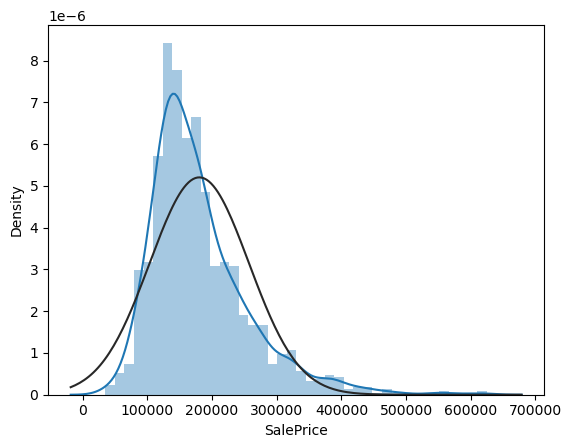

In [8]:
# histogram and normal probability plot
sns.distplot(df_train_subset['SalePrice'], fit=norm);

`SalePrice` has a positive/right skewness. From the plot, most house prices are in the price range of `$100,000` to `$200,000`.

One problem with this is that the models may not carry out proper prediction for higher prices since most of the prices exist in the lower range. This could lead to prediction bias towards the lower prices.

In order to correct this, I will carry out a data transformation on the `SalePrice` column. Specificaly, log transformation.

In [9]:
# Apply the log transformation to the SalePrice column
df_train_subset['SalePrice'] = np.log(df_train_subset['SalePrice'])

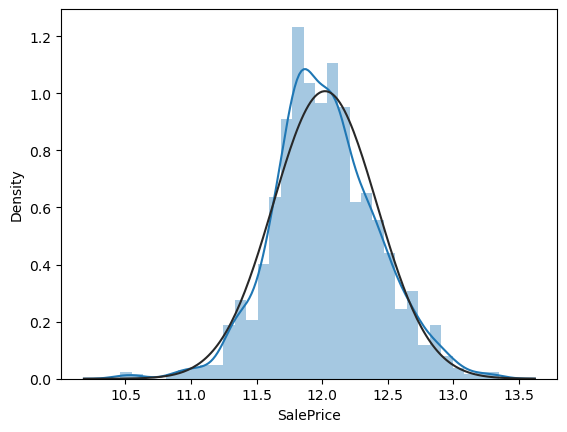

In [10]:
# histogram and normal probability plot with log transformed data
sns.distplot(df_train_subset['SalePrice'], fit=norm);

I will also check the other columns for skewness.

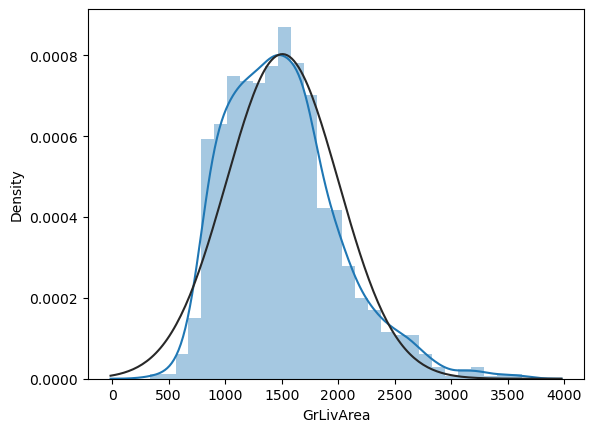

In [11]:
# histogram and normal probability plot 
sns.distplot(df_train_subset['GrLivArea'], fit=norm);

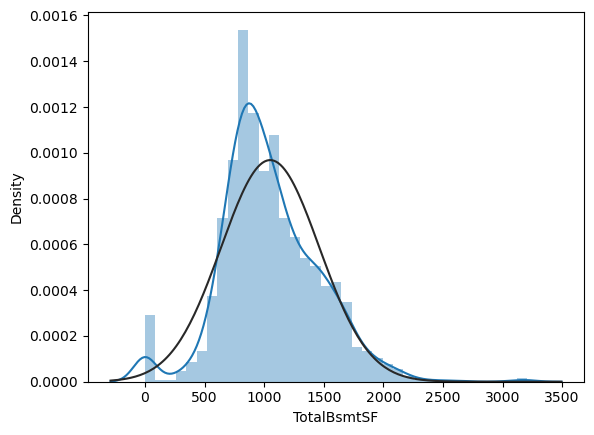

In [12]:
# histogram and normal probability plot
sns.distplot(df_train_subset['TotalBsmtSF'], fit=norm);

Both columns exhibit right skewness. Many values in the `TotalBsmtSF` column have `0` values. Let's see how many

In [13]:
len(df_train_subset.TotalBsmtSF[df_train_subset.TotalBsmtSF==0])

37

Yes, `37` rows. So, log transform will give infinity values.

I wanted to set each of the `0` values to a very tiny number. Howecer, this will create another outlier. I decided to drop all rows having `0` in the `TotalBsmtSF` column.

In [14]:
mask = df_train_subset.TotalBsmtSF==0

# Drop rows based on the mask
df_train_subset.drop(df_train_subset[mask].index, inplace=True)

In [16]:
# Apply the log transformation to the TotalBsmtSF column
df_train_subset['TotalBsmtSF'] = np.log(df_train_subset['TotalBsmtSF'])

# Apply the log transformation to the GrLivArea column
df_train_subset['GrLivArea'] = np.log(df_train_subset['GrLivArea'])

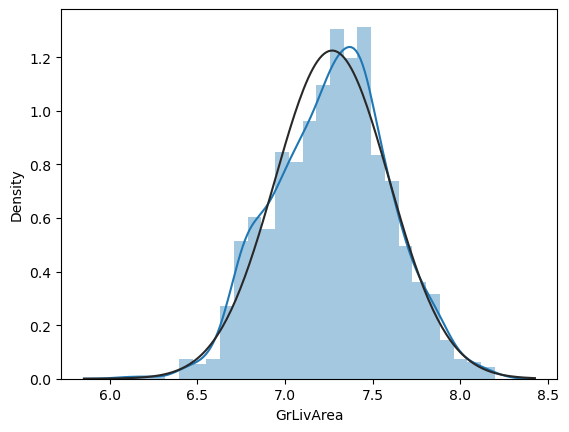

In [17]:
# histogram and normal probability plot with log transformed data
sns.distplot(df_train_subset['GrLivArea'], fit=norm);

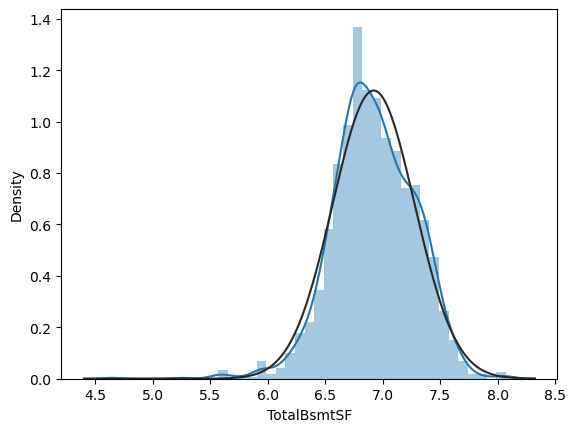

In [18]:
# histogram and normal probability plot with log transformed data
sns.distplot(df_train_subset['TotalBsmtSF'], fit=norm);

Alright. Since I will be testing on the test data set, I will need to drop all rows having `0` in `TotalBsmtSF` column for the test dataset. Then, log transform it also.

In [19]:
mask_test = df_test_subset.TotalBsmtSF==0

# Drop rows based on the mask
df_test_subset.drop(df_test_subset[mask_test].index, inplace=True)

df_test_subset[mask_test]

,Id,TotalBsmtSF,GrLivArea


In [62]:
# log transform the test dataset
# Apply the log transformation to the TotalBsmtSF column
df_test_subset['TotalBsmtSF'] = np.log(df_test_subset['TotalBsmtSF'])

# Apply the log transformation to the GrLivArea column
df_test_subset['GrLivArea'] = np.log(df_test_subset['GrLivArea'])

#### Scatter plots

Next, I want to create a scatter plot showing House prices (`SalePrice`) as a function of Ground Living Area (`GrLivArea`).

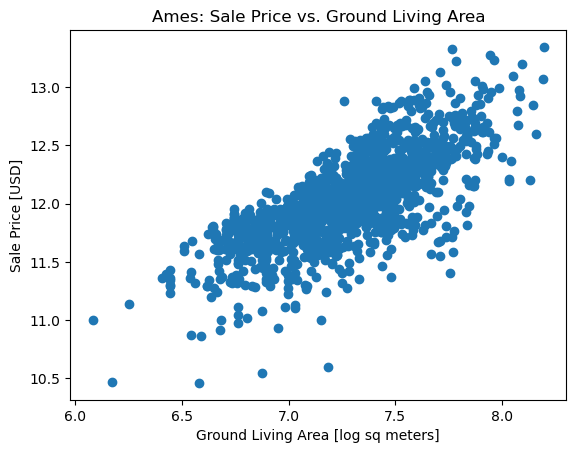

In [20]:
# Build scatter plot
plt.scatter(
    x=df_train_subset["GrLivArea"],
    y=df_train_subset["SalePrice"]
)

# Label axes
plt.xlabel("Ground Living Area [log sq meters]" )
plt.ylabel("Sale Price [USD]")

# Add title
plt.title("Ames: Sale Price vs. Ground Living Area")

plt.show()

There seem to be a strong Positive correlation between the Ground Living Area and the Sale Price of a Property. This makes sense, because a house price tends to be higher if the living quarters has a larger area.

Next, I want to do the same scatter plot, but this time between the Total square feet of basement area and the Sale Price.

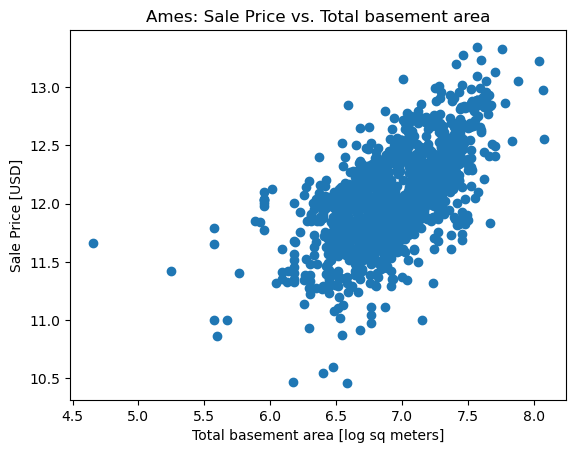

In [21]:
# Build scatter plot
plt.scatter(
    x=df_train_subset["TotalBsmtSF"],
    y=df_train_subset["SalePrice"]
)

# Label axes
plt.xlabel("Total basement area [log sq meters]" )
plt.ylabel("Sale Price [USD]")

# Add title
plt.title("Ames: Sale Price vs. Total basement area")

plt.show()

The same conclusion holds between the Total basement area and the Sale Price. It seems reasonable to conclude that the larger the Basement Area, the higher the Sale Price for an apartment.

### Split the dataset: Select Feature Matrix and target vector

Now I want to select the **feature matrix** (`X`) and the **target vector** (`y`).

In [89]:
feature_columns = ["GrLivArea", "TotalBsmtSF"]
target_column = "SalePrice"

# Select Feature matrix and target vector
X_train = df_train_subset[feature_columns]
y_train = df_train_subset[target_column]
X_test = df_test_subset[feature_columns]

### Build the model

#### Define the Baseline mean absolute error for the model

The baseline will help us know if our model is performing well.

In [39]:
y_mean = np.exp(y_train).mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(np.exp(y_train), y_pred_baseline)

print("Mean home sale price:", round(y_mean, 2))
print("Baseline MAE:", round(baseline_mae, 2))

Mean home sale price: 182093.76
Baseline MAE: 56554.43


This information here can be interpreted as follows:

If our model predicts the house price at `$180151.23`, the predictions will be off by an average of `$56614.92`. Therefore, our model has to have an error of at most `$56614.92` in order to be useful.

#### Create the `predict()` function

I want to first build a `predict()` method that will prevent me from repeating the model fitting, and testing over the two Regression models I am examining.

In [42]:
def predict(model, X_train, y_train):
    # Build and train the model
    model.fit(X_train, y_train)

    # Make predictions on the training set
    y_pred_train = model.predict(X_train)    

    # Get the mean absolute error for training
    y_train_exp_transformed = np.exp(y_train)
    y_pred_train_exp_transformed = np.exp(y_pred_train)
    mae_training = mean_absolute_error(y_train_exp_transformed, y_pred_train_exp_transformed) 

    return {
        "y_pred_train": y_pred_train_exp_transformed,
        "mae_training": mae_training,
    }

In [101]:
def test_model(model, X_test, y_train):
    # Since were using a log transformed dataset for the 
    # training dataset, transform it back

    # Make predictions on the test set
    y_pred_test = model.predict(X_test)  

    y_train_exp_transformed = np.exp(y_train)
    y_pred_test_exp_transformed = np.exp(y_pred_test)

    mae_testing = mean_absolute_error(y_train_exp_transformed, y_pred_test_exp_transformed)

    return {
        "y_pred_test": y_pred_test_exp_transformed,
        "mae_testing": mae_testing,
    }

#### Iterate: Fit, Evaluate and Test the Linear Regression model

In [106]:
linear_model = LinearRegression()
train_pred = predict(linear_model, X_train, y_train)
train_pred

{'y_pred_train': array([177738.20104317, 168472.6016598 , 188703.65445002, ...,
        249860.44514093, 141489.49553627, 167585.66116999]),
 'mae_training': 31369.88162988499}

This is Good news because our **mean absolute error** (`$31369.88`) is less than the **baseline mean absolute error** (`$56554.43`)!

In [71]:
# Check count of items in X_test vs y_train
print("X_test count: ", len(X_test))
print("y_train count: ", len(y_train))

X_test count:  1417
y_train count:  1419


I'll need to drop two rows from `y_train` to balance it with test data set

In [107]:
new_y_train = y_train.drop(y_train.index[:2])

test_pred = test_model(linear_model, X_test, new_y_train)
test_pred

{'y_pred_test': array([114544.71861177, 178407.16935368, 177581.27012727, ...,
        162863.05783994, 122742.47986314, 210967.74853665]),
 'mae_testing': 69359.89000233676}

The model performs worse than on the test dataset. since we've gotten a higher mean absolute error than the baseline mean value error. This is where we need to iterate.

#### Iterate: Fit, Evaluate and Test the Gradient Boosting Regressor model

In [94]:
gbr_model = GradientBoostingRegressor()
train_pred_gbr = predict(gbr_model, X_train, y_train)
train_pred_gbr

{'y_pred_train': array([168109.59943624, 167405.15845398, 178494.91593821, ...,
        269823.38083764, 137783.03720312, 165329.79263512]),
 'mae_training': 25732.323417695843}

The Gradient Boosting Regressor even performs better than the Linear Regression model. The **mean absolute error** (`$25732.38`) is smaller than the one I got for the Linear Regression model (`$31369.88`).

In [108]:
test_pred_gbr = test_model(gbr_model, X_test, new_y_train)
test_pred_gbr

{'y_pred_test': array([120537.54223245, 178199.50603965, 165710.47865636, ...,
        167738.68352805, 121681.80858347, 203315.2032991 ]),
 'mae_testing': 71887.14256812526}

The mean absolute error is worse here than even the Linear regression model. This is were I need to iterate.

### Save the results

In [111]:
def save_results(df, y_pred, filename):
    # Create a dictionary with "Id" and "SalePrice" columns
    result_data = {"Id": df["Id"], "SalePrice": y_pred}

    # Create a DataFrame from the dictionary
    df_Id_Sale = pd.DataFrame(result_data)

    # Save the result
    df_Id_Sale.to_csv(f"output/{filename}", index=False)

In [112]:
# Save the results for both the Linear regression Model
save_results(df_test_subset, test_pred["y_pred_test"], "linear-regression-results.csv")

# Save the results for both the Gradient Booster Regressor Model
save_results(df_test_subset, test_pred_gbr["y_pred_test"], "gradient-booster-regressor-results.csv")